# Exposure Universe Return Decomposition Analysis

This notebook demonstrates the complete return decomposition framework applied to our exposure universe. We'll analyze how returns break down into:
- **Real returns** (inflation-adjusted performance)
- **Inflation component** (purchasing power erosion)
- **Risk-free rate** (cash/leverage cost baseline)
- **Risk premium** (excess return over risk-free rate)

This analysis is crucial for:
1. Understanding which exposures provide real value after inflation
2. Identifying risk premiums across asset classes
3. Modeling leverage costs for synthetic exposures
4. Portfolio construction with inflation-aware optimization

In [1]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, str(Path().absolute().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

# Import our modules
from data.exposure_universe import ExposureUniverse
from data.total_returns import TotalReturnFetcher
from data.return_decomposition import ReturnDecomposer
from data.fred_data import FREDDataFetcher

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Libraries imported successfully")
print("🎯 Ready for exposure universe decomposition analysis")

📊 Libraries imported successfully
🎯 Ready for exposure universe decomposition analysis


## 1. Load Exposure Universe and Initialize Components

In [2]:
# Load exposure universe configuration
config_path = Path().absolute().parent / "config" / "exposure_universe.yaml"
universe = ExposureUniverse.from_yaml(str(config_path))

# Initialize data fetchers
fetcher = TotalReturnFetcher()
decomposer = ReturnDecomposer()
fred_fetcher = FREDDataFetcher()

print(f"🌍 Loaded exposure universe with {len(universe)} exposures")
print(f"📂 Categories: {', '.join(universe.get_all_categories())}")

# Display exposure overview
exposure_summary = []
for exposure in universe:
    exposure_summary.append({
        'ID': exposure.id,
        'Name': exposure.name,
        'Category': exposure.category,
        'Implementations': len(exposure.implementations),
        'Primary Type': exposure.implementations[0].type if exposure.implementations else 'None'
    })

summary_df = pd.DataFrame(exposure_summary)
print("\n📋 Exposure Universe Overview:")
display(summary_df.groupby('Category').agg({
    'ID': 'count',
    'Primary Type': lambda x: ', '.join(x.unique())
}).rename(columns={'ID': 'Count', 'Primary Type': 'Implementation Types'}))

🌍 Loaded exposure universe with 16 exposures
📂 Categories: factor_style, real_assets, alternatives, nominal_fixed_income, equity_beta

📋 Exposure Universe Overview:


,Count,Implementation Types
Category,,
alternatives,1,fund_average
equity_beta,5,etf_average
factor_style,2,fund
nominal_fixed_income,4,"etf_average, fund"
real_assets,4,etf_average


## 2. Set Analysis Parameters and Fetch Data

In [3]:
# Set analysis period
end_date = datetime.now()
start_date = end_date - timedelta(days=20*365)  # N years of data
frequency = "monthly"  # Monthly analysis for cleaner visualization

print(f"📅 Analysis Period: {start_date.date()} to {end_date.date()}")
print(f"📊 Frequency: {frequency.capitalize()}")
print(f"🔄 Fetching data for all {len(universe)} exposures...")

# Fetch returns for all exposures
universe_returns = fetcher.fetch_universe_returns(
    universe=universe,
    start_date=start_date,
    end_date=end_date,
    frequency=frequency
)

# Check success rate
successful_exposures = [exp_id for exp_id, data in universe_returns.items() if data['success']]
failed_exposures = [exp_id for exp_id, data in universe_returns.items() if not data['success']]

print(f"\n✅ Successfully fetched: {len(successful_exposures)}/{len(universe)} exposures")
if failed_exposures:
    print(f"❌ Failed exposures: {', '.join(failed_exposures)}")

# Create returns DataFrame
returns_data = {}
for exp_id in successful_exposures:
    returns_data[exp_id] = universe_returns[exp_id]['returns']

returns_df = pd.DataFrame(returns_data)
returns_df = returns_df.dropna(how='all')  # Remove rows with all NaN

print(f"\n📈 Returns matrix shape: {returns_df.shape}")
print(f"📅 Date range: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")

📅 Analysis Period: 2005-07-11 to 2025-07-06
📊 Frequency: Monthly
🔄 Fetching data for all 16 exposures...

✅ Successfully fetched: 16/16 exposures

📈 Returns matrix shape: (241, 16)
📅 Date range: 2005-07-31 to 2025-07-31


## 3. Perform Return Decomposition Analysis

In [4]:
# Perform decomposition for all exposures at once using the universe method
print("🔍 Performing return decomposition analysis...")

# Use the universe decomposition method for efficiency and consistency
decomposition_results = decomposer.decompose_universe_returns(
    universe=universe,
    start_date=start_date,
    end_date=end_date,
    frequency=frequency,
    inflation_series="cpi_all"
)

decomposition_summary = []

for exp_id, result in decomposition_results.items():
    print(f"  📊 Processing {exp_id}...")
    
    if 'decomposition' in result and 'summary' in result:
        decomposition_df = result['decomposition']
        summary = result['summary']
        
        exposure_info = universe.get_exposure(exp_id)
        
        # Convert summary to expected format
        decomposition_summary.append({
            'exposure_id': exp_id,
            'exposure_name': exposure_info.name if exposure_info else exp_id,
            'category': exposure_info.category if exposure_info else 'unknown',
            'nominal_return_annual': summary.get('total_return', 0),  # Already annualized by get_decomposition_summary
            'real_return_annual': summary.get('total_return', 0) - summary.get('inflation', 0),
            'inflation_annual': summary.get('inflation', 0),
            'risk_premium_annual': summary.get('spread', 0),
            'volatility_annual': decomposition_df['total_return'].std() * np.sqrt(12) if not decomposition_df.empty else 0,
            'sharpe_ratio': (summary.get('total_return', 0) / (decomposition_df['total_return'].std() * np.sqrt(12))) if not decomposition_df.empty and decomposition_df['total_return'].std() > 0 else 0,
            'real_sharpe_ratio': ((summary.get('total_return', 0) - summary.get('inflation', 0)) / (decomposition_df['total_return'].std() * np.sqrt(12))) if not decomposition_df.empty and decomposition_df['total_return'].std() > 0 else 0,
            'data_points': len(decomposition_df) if not decomposition_df.empty else 0
        })
    else:
        print(f"    ❌ Decomposition failed for {exp_id}")

# Create summary DataFrame
decomp_summary_df = pd.DataFrame(decomposition_summary)

print(f"\n🎯 Successfully decomposed {len(decomposition_results)} exposures")
print(f"📊 Summary statistics calculated for analysis period")

🔍 Performing return decomposition analysis...
  📊 Processing us_large_equity...
  📊 Processing us_small_equity...
  📊 Processing intl_developed_large_equity...
  📊 Processing intl_developed_small_equity...
  📊 Processing emerging_equity...
  📊 Processing factor_style_equity...
  📊 Processing factor_style_other...
  📊 Processing trend_following...
  📊 Processing cash_rate...
  📊 Processing short_ust...
  📊 Processing broad_ust...
  📊 Processing dynamic_global_bonds...
  📊 Processing real_estate...
  📊 Processing commodities...
  📊 Processing gold...
  📊 Processing tips...

🎯 Successfully decomposed 16 exposures
📊 Summary statistics calculated for analysis period


## 4. Summary Statistics and Rankings

In [5]:
# Display summary statistics
if not decomp_summary_df.empty:
    print("📈 EXPOSURE UNIVERSE DECOMPOSITION SUMMARY")
    print("=" * 60)
    
    # Format for display
    display_df = decomp_summary_df.copy()
    display_df['nominal_return_annual'] = (display_df['nominal_return_annual'] * 100).round(2)
    display_df['real_return_annual'] = (display_df['real_return_annual'] * 100).round(2)
    display_df['inflation_annual'] = (display_df['inflation_annual'] * 100).round(2)
    display_df['risk_premium_annual'] = (display_df['risk_premium_annual'] * 100).round(2)
    display_df['volatility_annual'] = (display_df['volatility_annual'] * 100).round(2)
    display_df['sharpe_ratio'] = display_df['sharpe_ratio'].round(3)
    display_df['real_sharpe_ratio'] = display_df['real_sharpe_ratio'].round(3)
    
    # Rename columns for clarity
    display_df = display_df.rename(columns={
        'exposure_name': 'Exposure',
        'category': 'Category',
        'nominal_return_annual': 'Nominal Return (%)',
        'real_return_annual': 'Real Return (%)',
        'inflation_annual': 'Inflation Impact (%)',
        'risk_premium_annual': 'Risk Premium (%)',
        'volatility_annual': 'Volatility (%)',
        'sharpe_ratio': 'Sharpe Ratio',
        'real_sharpe_ratio': 'Real Sharpe',
        'data_points': 'Data Points'
    })
    
    # Sort by real returns
    display_df = display_df.sort_values('Real Return (%)', ascending=False)
    
    # Display full summary
    display(display_df[['Exposure', 'Category', 'Nominal Return (%)', 'Real Return (%)', 
                       'Inflation Impact (%)', 'Risk Premium (%)', 'Volatility (%)', 
                       'Sharpe Ratio', 'Real Sharpe']].round(2))
    
    # Category summary
    print("\n🏷️ PERFORMANCE BY CATEGORY")
    print("-" * 40)
    category_stats = decomp_summary_df.groupby('category').agg({
        'real_return_annual': ['mean', 'std', 'min', 'max'],
        'volatility_annual': 'mean',
        'real_sharpe_ratio': 'mean',
        'exposure_id': 'count'
    }).round(4)
    
    category_stats.columns = ['Mean Real Return', 'Std Real Return', 'Min Real Return', 
                             'Max Real Return', 'Avg Volatility', 'Avg Real Sharpe', 'Count']
    
    # Convert to percentages
    for col in ['Mean Real Return', 'Std Real Return', 'Min Real Return', 'Max Real Return', 'Avg Volatility']:
        category_stats[col] = (category_stats[col] * 100).round(2)
    
    category_stats['Avg Real Sharpe'] = category_stats['Avg Real Sharpe'].round(3)
    
    display(category_stats)
else:
    print("❌ No successful decompositions to display")

📈 EXPOSURE UNIVERSE DECOMPOSITION SUMMARY


,Exposure,Category,Nominal Return (%),Real Return (%),Inflation Impact (%),Risk Premium (%),Volatility (%),Sharpe Ratio,Real Sharpe
0,US Large Cap Equity Beta,equity_beta,10.85,8.35,2.50,9.22,13.66,0.79,0.61
1,US Small Cap Equity Beta,equity_beta,9.79,7.29,2.50,8.16,19.81,0.49,0.37
14,Gold,real_assets,9.31,6.81,2.50,7.68,12.86,0.72,0.53
5,Factor/Style - Equities,factor_style,7.84,5.00,2.85,5.96,9.86,0.80,0.51
3,Developed Ex-US Small Cap Equity Beta,equity_beta,7.25,4.85,2.40,6.00,18.45,0.39,0.26
6,Factor/Style - Other,factor_style,7.42,4.68,2.74,5.70,12.93,0.57,0.36
4,Emerging Markets Equity Beta,equity_beta,6.01,3.51,2.50,4.39,16.82,0.36,0.21
12,Real Estate,real_assets,5.94,3.44,2.50,4.32,15.47,0.38,0.22
2,Developed Ex-US Large Cap Equity Beta,equity_beta,5.64,3.14,2.50,4.01,14.32,0.39,0.22
11,Dynamic Global Bonds,nominal_fixed_income,3.74,1.46,2.27,2.51,3.27,1.14,0.45



🏷️ PERFORMANCE BY CATEGORY
----------------------------------------


,Mean Real Return,Std Real Return,Min Real Return,Max Real Return,Avg Volatility,Avg Real Sharpe,Count
category,,,,,,,
alternatives,0.43,NaN,0.43,0.43,8.51,0.051,1
equity_beta,5.43,2.30,3.14,8.35,16.61,0.334,5
factor_style,4.84,0.22,4.68,5.00,11.39,0.434,2
nominal_fixed_income,-0.26,1.24,-1.39,1.46,2.38,-0.573,4
real_assets,2.09,3.78,-1.40,6.81,11.67,0.130,4


## 5. Visualization: Return Decomposition Waterfall Charts

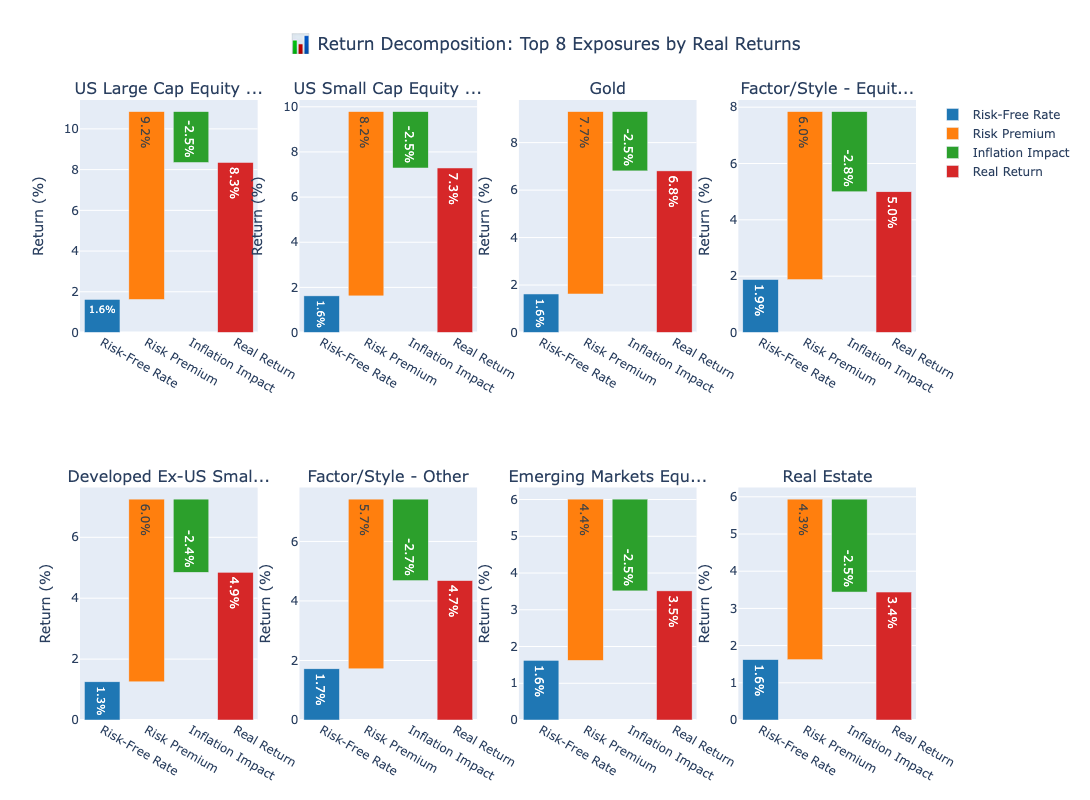


🔍 Sample Decomposition for US Large Cap Equity Beta:
   Risk-Free Rate: 1.62%
   Risk Premium: 9.22%
   → Total Nominal: 10.85%
   Inflation Impact: -2.50%
   → Real Return: 8.35%
   Verification: 1.62% + 9.22% - 2.50% = 8.35%


In [6]:
# Create waterfall chart showing decomposition for top performers
if not decomp_summary_df.empty:
    # Select top 8 performers by real returns for visualization
    top_performers = decomp_summary_df.nlargest(8, 'real_return_annual')
    
    fig = make_subplots(
        rows=2, cols=4,
        subplot_titles=[exp[:20] + '...' if len(exp) > 20 else exp 
                       for exp in top_performers['exposure_name']],
        specs=[[{"secondary_y": False} for _ in range(4)] for _ in range(2)]
    )
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for idx, (_, row) in enumerate(top_performers.iterrows()):
        row_pos = idx // 4 + 1
        col_pos = idx % 4 + 1
        
        # Decomposition components (annualized %) - CORRECTED
        # Total Return = Risk-Free Rate + Risk Premium
        # Real Return = Total Return - Inflation
        risk_free_rate = row['nominal_return_annual'] - row['risk_premium_annual']  # This should be the cash/risk-free rate
        
        components = [
            ('Risk-Free Rate', risk_free_rate * 100, colors[0]),
            ('Risk Premium', row['risk_premium_annual'] * 100, colors[1]),
            ('Inflation Impact', -row['inflation_annual'] * 100, colors[2]),
            ('Real Return', row['real_return_annual'] * 100, colors[3])
        ]
        
        # Create waterfall effect
        x_labels = [comp[0] for comp in components]
        values = [comp[1] for comp in components]
        colors_list = [comp[2] for comp in components]
        
        # Calculate cumulative for waterfall
        cumulative = [0]
        for i, val in enumerate(values[:-1]):
            cumulative.append(cumulative[-1] + val)
        
        # Add bars
        for i, (label, value, color) in enumerate(components):
            if i < len(components) - 1:  # Not the final bar
                fig.add_trace(
                    go.Bar(
                        x=[label],
                        y=[value],
                        base=[cumulative[i]],
                        marker_color=color,
                        showlegend=(idx == 0),
                        name=label if idx == 0 else None,
                        text=f"{value:.1f}%",
                        textposition="inside"
                    ),
                    row=row_pos, col=col_pos
                )
            else:  # Final bar (real return)
                fig.add_trace(
                    go.Bar(
                        x=[label],
                        y=[value],
                        marker_color=color,
                        showlegend=(idx == 0),
                        name=label if idx == 0 else None,
                        text=f"{value:.1f}%",
                        textposition="inside"
                    ),
                    row=row_pos, col=col_pos
                )
    
    fig.update_layout(
        title_text="📊 Return Decomposition: Top 8 Exposures by Real Returns",
        title_x=0.5,
        height=800,
        showlegend=True
    )
    
    # Update y-axes
    for i in range(1, 9):
        row = (i-1) // 4 + 1
        col = (i-1) % 4 + 1
        fig.update_yaxes(title_text="Return (%)", row=row, col=col)
    
    fig.show()
    
    # Print a sample decomposition to verify the math
    if not top_performers.empty:
        sample = top_performers.iloc[0]
        print(f"\n🔍 Sample Decomposition for {sample['exposure_name']}:")
        rf_rate = sample['nominal_return_annual'] - sample['risk_premium_annual']
        print(f"   Risk-Free Rate: {rf_rate*100:.2f}%")
        print(f"   Risk Premium: {sample['risk_premium_annual']*100:.2f}%")
        print(f"   → Total Nominal: {sample['nominal_return_annual']*100:.2f}%")
        print(f"   Inflation Impact: -{sample['inflation_annual']*100:.2f}%")
        print(f"   → Real Return: {sample['real_return_annual']*100:.2f}%")
        print(f"   Verification: {rf_rate*100:.2f}% + {sample['risk_premium_annual']*100:.2f}% - {sample['inflation_annual']*100:.2f}% = {(rf_rate + sample['risk_premium_annual'] - sample['inflation_annual'])*100:.2f}%")
        
else:
    print("❌ No data available for waterfall visualization")

## 6. Risk-Return Analysis: Real vs Nominal

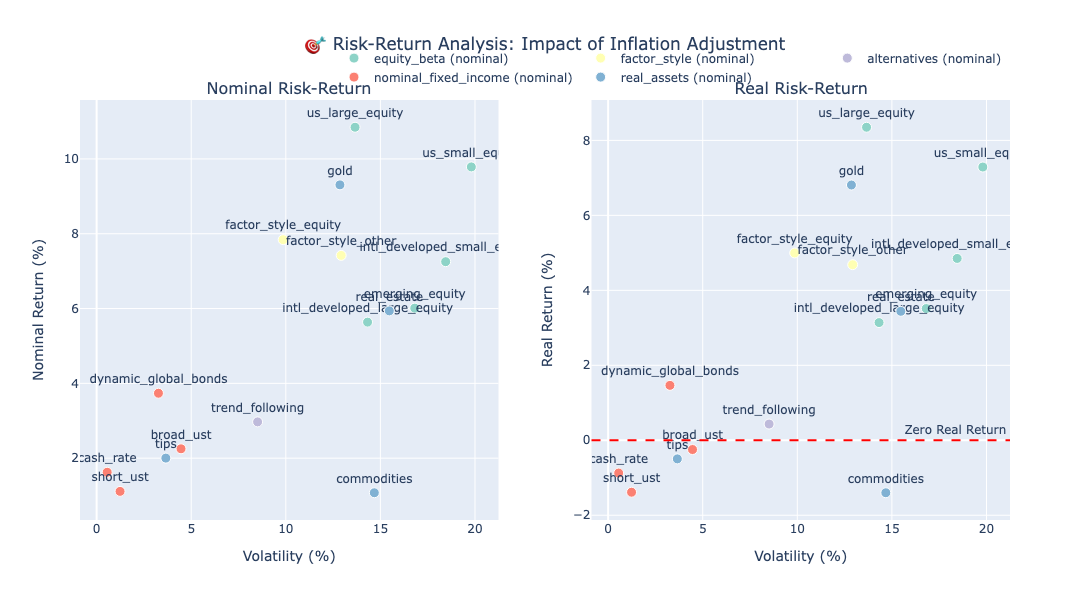

In [7]:
# Create risk-return scatter plot comparing nominal vs real returns
if not decomp_summary_df.empty:
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Nominal Risk-Return", "Real Risk-Return"),
        horizontal_spacing=0.1
    )
    
    # Category colors
    categories = decomp_summary_df['category'].unique()
    category_colors = px.colors.qualitative.Set3[:len(categories)]
    color_map = dict(zip(categories, category_colors))
    
    # Nominal risk-return
    for category in categories:
        cat_data = decomp_summary_df[decomp_summary_df['category'] == category]
        
        fig.add_trace(
            go.Scatter(
                x=cat_data['volatility_annual'] * 100,
                y=cat_data['nominal_return_annual'] * 100,
                mode='markers+text',
                marker=dict(
                    size=10,
                    color=color_map[category],
                    line=dict(width=1, color='white')
                ),
                text=cat_data['exposure_id'],
                textposition="top center",
                name=f"{category} (nominal)",
                showlegend=True,
                hovertemplate="<b>%{text}</b><br>" +
                             "Return: %{y:.1f}%<br>" +
                             "Volatility: %{x:.1f}%<extra></extra>"
            ),
            row=1, col=1
        )
    
    # Real risk-return
    for category in categories:
        cat_data = decomp_summary_df[decomp_summary_df['category'] == category]
        
        fig.add_trace(
            go.Scatter(
                x=cat_data['volatility_annual'] * 100,
                y=cat_data['real_return_annual'] * 100,
                mode='markers+text',
                marker=dict(
                    size=10,
                    color=color_map[category],
                    line=dict(width=1, color='white')
                ),
                text=cat_data['exposure_id'],
                textposition="top center",
                name=f"{category} (real)",
                showlegend=False,  # Don't duplicate legend
                hovertemplate="<b>%{text}</b><br>" +
                             "Real Return: %{y:.1f}%<br>" +
                             "Volatility: %{x:.1f}%<extra></extra>"
            ),
            row=1, col=2
        )
    
    # Add zero lines for real returns
    fig.add_hline(y=0, line_dash="dash", line_color="red", 
                  annotation_text="Zero Real Return", row=1, col=2)
    
    # Update layout
    fig.update_layout(
        title_text="🎯 Risk-Return Analysis: Impact of Inflation Adjustment",
        title_x=0.5,
        height=600,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # Update axes
    fig.update_xaxes(title_text="Volatility (%)", row=1, col=1)
    fig.update_xaxes(title_text="Volatility (%)", row=1, col=2)
    fig.update_yaxes(title_text="Nominal Return (%)", row=1, col=1)
    fig.update_yaxes(title_text="Real Return (%)", row=1, col=2)
    
    fig.show()
else:
    print("❌ No data available for risk-return analysis")

## 7. Time Series Analysis: Real vs Nominal Performance

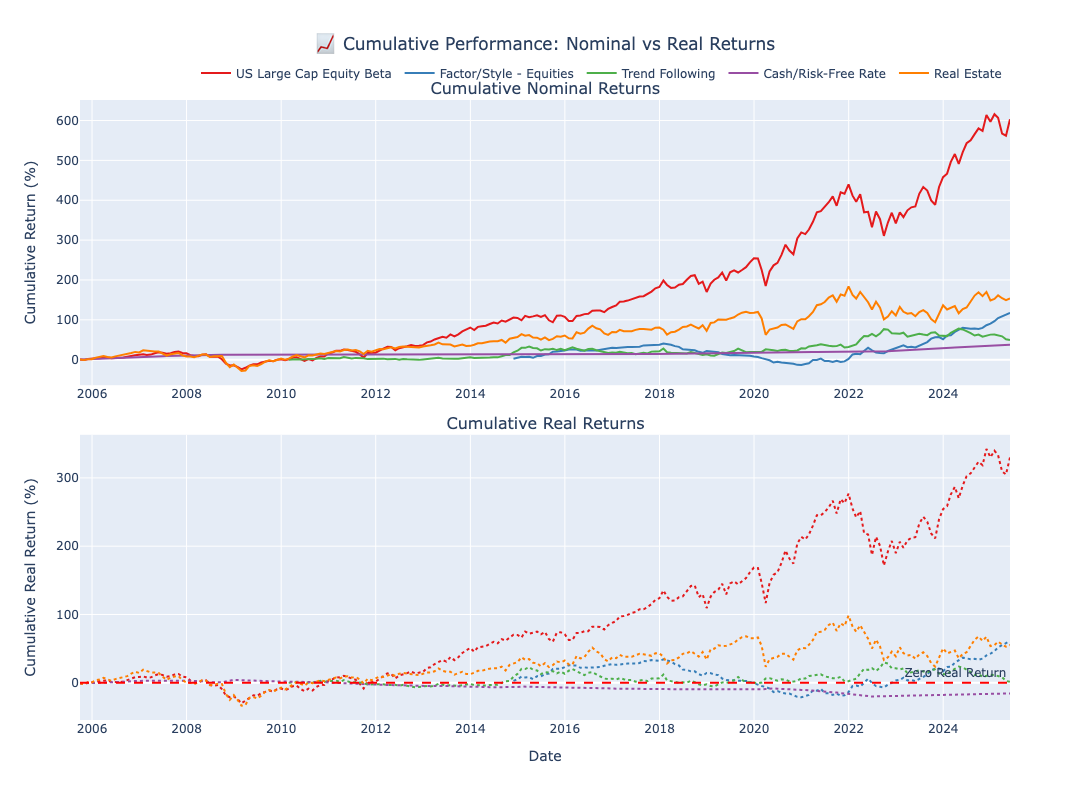

In [8]:
# Show cumulative performance for selected exposures
if decomposition_results:
    # Select representative exposures from each category
    selected_exposures = []
    categories_seen = set()
    
    if not decomp_summary_df.empty:
        for _, row in decomp_summary_df.iterrows():
            if row['category'] not in categories_seen:
                selected_exposures.append(row['exposure_id'])
                categories_seen.add(row['category'])
                if len(selected_exposures) >= 5:  # Limit to 5 for clarity
                    break
    else:
        # Fallback to first 5 exposures
        selected_exposures = list(decomposition_results.keys())[:5]
    
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Cumulative Nominal Returns", "Cumulative Real Returns"),
        vertical_spacing=0.08
    )
    
    colors = px.colors.qualitative.Set1[:len(selected_exposures)]
    
    for i, exp_id in enumerate(selected_exposures):
        if exp_id in decomposition_results:
            result = decomposition_results[exp_id]
            decomposition_df = result['decomposition']
            
            if not decomposition_df.empty:
                # Calculate cumulative returns
                nominal_cumret = (1 + decomposition_df['total_return']).cumprod() - 1
                # Calculate real returns: (1 + nominal) / (1 + inflation) - 1
                real_returns = (1 + decomposition_df['total_return']) / (1 + decomposition_df['inflation']) - 1
                real_cumret = (1 + real_returns).cumprod() - 1
                
                exposure_info = universe.get_exposure(exp_id)
                name = exposure_info.name[:30] if exposure_info else exp_id
                
                # Nominal returns
                fig.add_trace(
                    go.Scatter(
                        x=nominal_cumret.index,
                        y=nominal_cumret * 100,
                        mode='lines',
                        name=name,
                        line=dict(color=colors[i], width=2),
                        showlegend=True
                    ),
                    row=1, col=1
                )
                
                # Real returns
                fig.add_trace(
                    go.Scatter(
                        x=real_cumret.index,
                        y=real_cumret * 100,
                        mode='lines',
                        name=name,
                        line=dict(color=colors[i], width=2, dash='dot'),
                        showlegend=False
                    ),
                    row=2, col=1
                )
    
    # Add zero line for real returns
    fig.add_hline(y=0, line_dash="dash", line_color="red", 
                  annotation_text="Zero Real Return", row=2, col=1)
    
    fig.update_layout(
        title_text="📈 Cumulative Performance: Nominal vs Real Returns",
        title_x=0.5,
        height=800,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    fig.update_yaxes(title_text="Cumulative Return (%)", row=1, col=1)
    fig.update_yaxes(title_text="Cumulative Real Return (%)", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    
    fig.show()
else:
    print("❌ No decomposition results available for time series analysis")

## 8. Inflation Impact Analysis

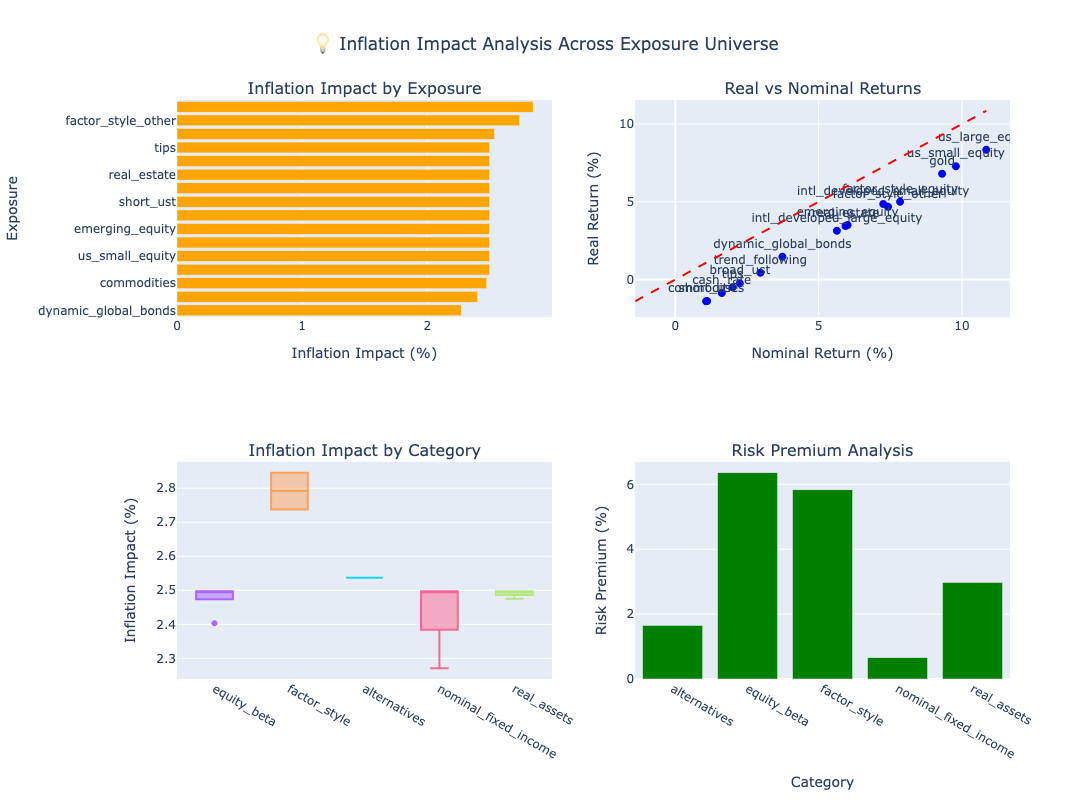


🔍 KEY INSIGHTS:
📊 Average inflation impact: 2.52% annually
✅ Exposures with positive real returns: 11/16 (68.8%)
🏆 Best real return: US Large Cap Equity Beta (8.35%)
📉 Worst real return: Broad Commodities (-1.40%)

🏷️ Best performing category: equity_beta (5.43% avg real return)
📊 Worst performing category: nominal_fixed_income (-0.26% avg real return)


In [9]:
# Analyze inflation impact across exposures
if not decomp_summary_df.empty:
    # Create inflation impact visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Inflation Impact by Exposure",
            "Real vs Nominal Returns",
            "Inflation Impact by Category",
            "Risk Premium Analysis"
        ),
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "box"}, {"type": "bar"}]]
    )
    
    # 1. Inflation impact by exposure (bar chart)
    sorted_data = decomp_summary_df.sort_values('inflation_annual', ascending=True)
    
    fig.add_trace(
        go.Bar(
            x=sorted_data['inflation_annual'] * 100,
            y=sorted_data['exposure_id'],
            orientation='h',
            marker_color='orange',
            name='Inflation Impact',
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 2. Real vs Nominal scatter
    fig.add_trace(
        go.Scatter(
            x=decomp_summary_df['nominal_return_annual'] * 100,
            y=decomp_summary_df['real_return_annual'] * 100,
            mode='markers+text',
            text=decomp_summary_df['exposure_id'],
            textposition="top center",
            marker=dict(size=8, color='blue'),
            name='Exposures',
            showlegend=False
        ),
        row=1, col=2
    )
    
    # Add diagonal line (real = nominal)
    min_ret = min(decomp_summary_df['nominal_return_annual'].min(),
                  decomp_summary_df['real_return_annual'].min()) * 100
    max_ret = max(decomp_summary_df['nominal_return_annual'].max(),
                  decomp_summary_df['real_return_annual'].max()) * 100
    
    fig.add_trace(
        go.Scatter(
            x=[min_ret, max_ret],
            y=[min_ret, max_ret],
            mode='lines',
            line=dict(dash='dash', color='red'),
            name='Real = Nominal',
            showlegend=False
        ),
        row=1, col=2
    )
    
    # 3. Inflation impact by category (box plot)
    for category in decomp_summary_df['category'].unique():
        cat_data = decomp_summary_df[decomp_summary_df['category'] == category]
        
        fig.add_trace(
            go.Box(
                y=cat_data['inflation_annual'] * 100,
                name=category,
                showlegend=False
            ),
            row=2, col=1
        )
    
    # 4. Risk premium by category
    risk_premium_by_cat = decomp_summary_df.groupby('category')['risk_premium_annual'].mean()
    
    fig.add_trace(
        go.Bar(
            x=risk_premium_by_cat.index,
            y=risk_premium_by_cat * 100,
            marker_color='green',
            name='Risk Premium',
            showlegend=False
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="💡 Inflation Impact Analysis Across Exposure Universe",
        title_x=0.5,
        height=800
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Inflation Impact (%)", row=1, col=1)
    fig.update_yaxes(title_text="Exposure", row=1, col=1)
    
    fig.update_xaxes(title_text="Nominal Return (%)", row=1, col=2)
    fig.update_yaxes(title_text="Real Return (%)", row=1, col=2)
    
    fig.update_yaxes(title_text="Inflation Impact (%)", row=2, col=1)
    
    fig.update_xaxes(title_text="Category", row=2, col=2)
    fig.update_yaxes(title_text="Risk Premium (%)", row=2, col=2)
    
    fig.show()
    
    # Print summary insights
    print("\n🔍 KEY INSIGHTS:")
    print("=" * 40)
    
    avg_inflation = decomp_summary_df['inflation_annual'].mean() * 100
    positive_real_returns = (decomp_summary_df['real_return_annual'] > 0).sum()
    total_exposures = len(decomp_summary_df)
    
    print(f"📊 Average inflation impact: {avg_inflation:.2f}% annually")
    print(f"✅ Exposures with positive real returns: {positive_real_returns}/{total_exposures} ({positive_real_returns/total_exposures*100:.1f}%)")
    
    best_real_return = decomp_summary_df.loc[decomp_summary_df['real_return_annual'].idxmax()]
    worst_real_return = decomp_summary_df.loc[decomp_summary_df['real_return_annual'].idxmin()]
    
    print(f"🏆 Best real return: {best_real_return['exposure_name']} ({best_real_return['real_return_annual']*100:.2f}%)")
    print(f"📉 Worst real return: {worst_real_return['exposure_name']} ({worst_real_return['real_return_annual']*100:.2f}%)")
    
    # Category performance
    cat_performance = decomp_summary_df.groupby('category')['real_return_annual'].mean().sort_values(ascending=False)
    print(f"\n🏷️ Best performing category: {cat_performance.index[0]} ({cat_performance.iloc[0]*100:.2f}% avg real return)")
    print(f"📊 Worst performing category: {cat_performance.index[-1]} ({cat_performance.iloc[-1]*100:.2f}% avg real return)")

else:
    print("❌ No data available for inflation impact analysis")

## 9. Risk-Free Rate and Cash Analysis

💰 CASH RATE AND RISK-FREE RATE ANALYSIS


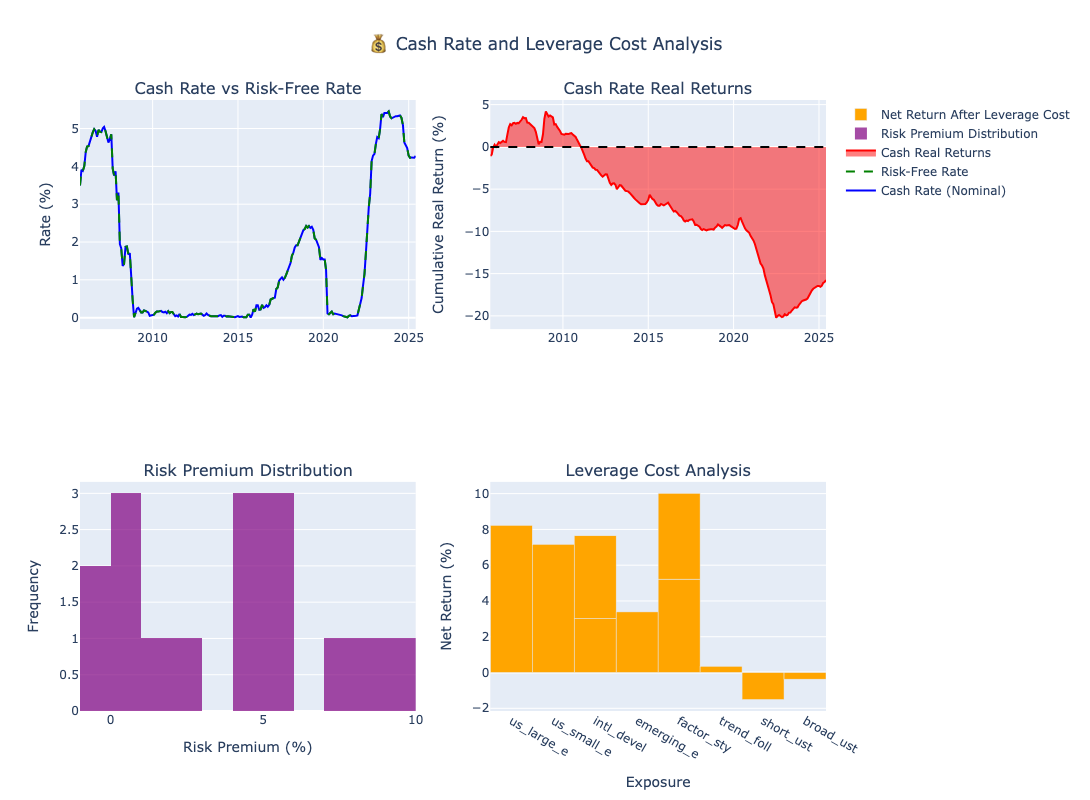


📊 Cash Rate Performance (Annualized):
   Nominal Return: 1.62%
   Real Return: -0.87%
   Inflation Impact: 2.50%
   Risk Premium: 0.00%

💹 Latest Risk-Free Rate: 4.28% (annualized)
🏦 Typical Leverage Cost: 5.28% (risk-free + 1% spread)


In [10]:
# Analyze risk-free rate and cash rate exposure specifically
print("💰 CASH RATE AND RISK-FREE RATE ANALYSIS")
print("=" * 50)

# Get cash rate exposure data
cash_exposure_id = 'cash_rate'
if cash_exposure_id in decomposition_results:
    cash_result = decomposition_results[cash_exposure_id]
    cash_decomposition = cash_result['decomposition']
    
    # Create visualization of cash rate decomposition
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Cash Rate vs Risk-Free Rate",
            "Cash Rate Real Returns",
            "Risk Premium Distribution",
            "Leverage Cost Analysis"
        )
    )
    
    # 1. Cash rate vs risk-free rate time series
    if not cash_decomposition.empty:
        fig.add_trace(
            go.Scatter(
                x=cash_decomposition.index,
                y=cash_decomposition['total_return'] * 1200,  # Annualized %
                mode='lines',
                name='Cash Rate (Nominal)',
                line=dict(color='blue')
            ),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=cash_decomposition.index,
                y=cash_decomposition['nominal_rf_rate'] * 1200,  # Annualized %
                mode='lines',
                name='Risk-Free Rate',
                line=dict(color='green', dash='dash')
            ),
            row=1, col=1
        )
        
        # 2. Cash rate real returns
        real_returns = (1 + cash_decomposition['total_return']) / (1 + cash_decomposition['inflation']) - 1
        cash_real_cumret = (1 + real_returns).cumprod() - 1
        
        fig.add_trace(
            go.Scatter(
                x=cash_real_cumret.index,
                y=cash_real_cumret * 100,
                mode='lines',
                name='Cash Real Returns',
                line=dict(color='red'),
                fill='tonexty'
            ),
            row=1, col=2
        )
        
        fig.add_hline(y=0, line_dash="dash", line_color="black", row=1, col=2)
    
    # 3. Risk premium distribution across all exposures
    if not decomp_summary_df.empty:
        fig.add_trace(
            go.Histogram(
                x=decomp_summary_df['risk_premium_annual'] * 100,
                nbinsx=15,
                name='Risk Premium Distribution',
                marker_color='purple',
                opacity=0.7
            ),
            row=2, col=1
        )
    
    # 4. Leverage cost analysis
    # Show cash rate vs other exposures for leverage cost modeling
    if not decomp_summary_df.empty:
        cash_return = decomp_summary_df[decomp_summary_df['exposure_id'] == 'cash_rate']['nominal_return_annual'].iloc[0] * 100
        
        leverage_costs = []
        exposure_names = []
        
        for _, row in decomp_summary_df.iterrows():
            if row['exposure_id'] != 'cash_rate':
                # Typical leverage spread: 0.5-1.5% over cash rate
                leverage_cost = cash_return + 1.0  # 1% spread
                net_return = row['nominal_return_annual'] * 100 - leverage_cost
                leverage_costs.append(net_return)
                exposure_names.append(row['exposure_id'][:10])
        
        fig.add_trace(
            go.Bar(
                x=exposure_names[:10],  # Top 10 for readability
                y=leverage_costs[:10],
                marker_color='orange',
                name='Net Return After Leverage Cost'
            ),
            row=2, col=2
        )
    
    # Update layout
    fig.update_layout(
        title_text="💰 Cash Rate and Leverage Cost Analysis",
        title_x=0.5,
        height=800,
        showlegend=True
    )
    
    # Update axes
    fig.update_yaxes(title_text="Rate (%)", row=1, col=1)
    fig.update_yaxes(title_text="Cumulative Real Return (%)", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=2, col=1)
    fig.update_xaxes(title_text="Risk Premium (%)", row=2, col=1)
    fig.update_yaxes(title_text="Net Return (%)", row=2, col=2)
    fig.update_xaxes(title_text="Exposure", row=2, col=2)
    
    fig.show()
    
    # Print cash rate statistics
    cash_summary = cash_result['summary']
    print(f"\n📊 Cash Rate Performance (Annualized):")
    print(f"   Nominal Return: {cash_summary.get('total_return', 0) * 100:.2f}%")
    print(f"   Real Return: {(cash_summary.get('total_return', 0) - cash_summary.get('inflation', 0)) * 100:.2f}%")
    print(f"   Inflation Impact: {cash_summary.get('inflation', 0) * 100:.2f}%")
    print(f"   Risk Premium: {cash_summary.get('spread', 0) * 100:.2f}%")
    
    # Latest risk-free rate
    if not cash_decomposition.empty:
        latest_rf_rate = cash_decomposition['nominal_rf_rate'].iloc[-1] * 1200
        print(f"\n💹 Latest Risk-Free Rate: {latest_rf_rate:.2f}% (annualized)")
        print(f"🏦 Typical Leverage Cost: {latest_rf_rate + 1.0:.2f}% (risk-free + 1% spread)")
    
else:
    print("❌ Cash rate exposure not found or decomposition failed")
    
    # Still show current FRED rates
    try:
        current_rates = fred_fetcher.get_latest_rates()
        print("\n📈 Current FRED Rates:")
        for rate_name, rate_value in current_rates.items():
            if rate_value is not None:
                print(f"   {rate_name}: {rate_value*100:.2f}%")
    except Exception as e:
        print(f"❌ Could not fetch current rates: {e}")

## 9. Correlation Analysis: Nominal vs Real Risk Premia

🔗 CORRELATION ANALYSIS: NOMINAL vs REAL RISK PREMIA
📊 Extracting time series data for correlation analysis...
✅ Collected data for 16 exposures
📅 Analysis period: 2005-09-30 to 2025-05-31


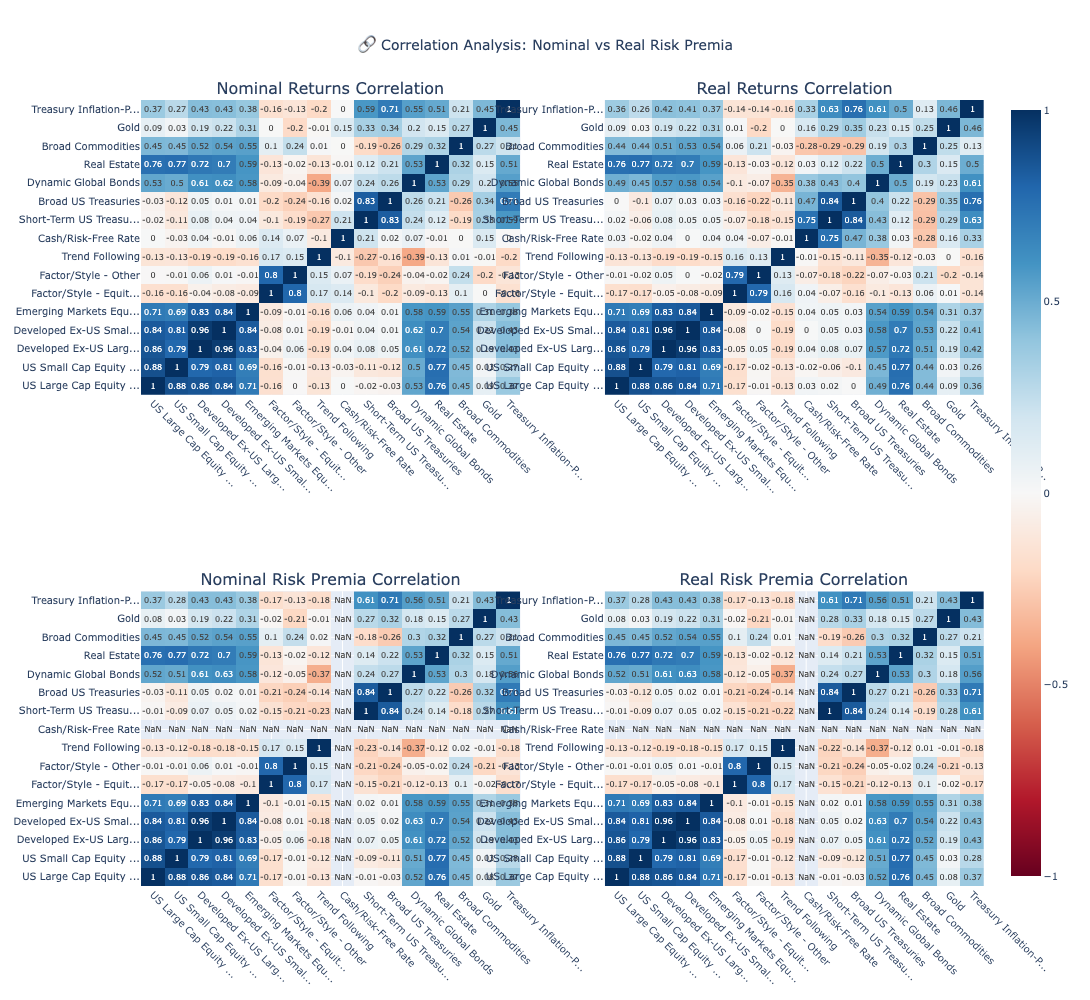


📈 CORRELATION ANALYSIS INSIGHTS
🏷️ WITHIN-CATEGORY vs CROSS-CATEGORY CORRELATIONS:
--------------------------------------------------
Nominal:
  Within-category: 0.547 (avg of 23 pairs)
  Cross-category:  0.124 (avg of 97 pairs)
  Difference:      0.423

Real:
  Within-category: 0.612 (avg of 23 pairs)
  Cross-category:  0.123 (avg of 97 pairs)
  Difference:      0.488

Risk Premium:
  Within-category: 0.614 (avg of 20 pairs)
  Cross-category:  0.137 (avg of 85 pairs)
  Difference:      0.477

Real Risk Premium:
  Within-category: 0.614 (avg of 20 pairs)
  Cross-category:  0.137 (avg of 85 pairs)
  Difference:      0.477

🔍 EXTREME CORRELATIONS:
------------------------------

Nominal Risk Premia:
  Highest correlations:
    Developed Ex-US - Developed Ex-US: 0.957
    US Large Cap Eq - US Small Cap Eq: 0.882
    US Large Cap Eq - Developed Ex-US: 0.864
  Lowest correlations:
    Factor/Style -  - Broad US Treasu: -0.242
    Broad US Treasu - Broad Commoditi: -0.258
    Trend Followin

In [11]:
# Comprehensive correlation analysis for risk premia across the exposure universe
print("🔗 CORRELATION ANALYSIS: NOMINAL vs REAL RISK PREMIA")
print("=" * 65)

if decomposition_results and len(decomposition_results) >= 3:  # Need at least 3 exposures for meaningful correlation
    
    # Step 1: Extract time series data for all exposures
    print("📊 Extracting time series data for correlation analysis...")
    
    # Create DataFrames for different return components
    nominal_returns_df = pd.DataFrame()
    real_returns_df = pd.DataFrame()
    risk_premia_df = pd.DataFrame()
    real_risk_premia_df = pd.DataFrame()
    
    exposure_names = {}  # Map exposure_id to readable names
    
    for exp_id, result in decomposition_results.items():
        decomposition_df = result['decomposition']
        
        if not decomposition_df.empty:
            exposure_info = universe.get_exposure(exp_id)
            display_name = exposure_info.name[:20] + "..." if len(exposure_info.name) > 20 else exposure_info.name
            exposure_names[exp_id] = display_name
            
            # Extract time series
            nominal_returns_df[exp_id] = decomposition_df['total_return']
            
            # Calculate real returns: (1 + nominal) / (1 + inflation) - 1
            real_returns = (1 + decomposition_df['total_return']) / (1 + decomposition_df['inflation']) - 1
            real_returns_df[exp_id] = real_returns
            
            # Risk premium = Total Return - Risk-Free Rate
            risk_premia_df[exp_id] = decomposition_df['spread']
            
            # Real risk premium = Real Return - Real Risk-Free Rate
            real_rf_rate = (1 + decomposition_df['nominal_rf_rate']) / (1 + decomposition_df['inflation']) - 1
            real_risk_premia_df[exp_id] = real_returns - real_rf_rate
    
    print(f"✅ Collected data for {len(nominal_returns_df.columns)} exposures")
    print(f"📅 Analysis period: {nominal_returns_df.index[0].date()} to {nominal_returns_df.index[-1].date()}")
    
    # Step 2: Calculate correlation matrices
    nominal_corr = nominal_returns_df.corr()
    real_corr = real_returns_df.corr()
    risk_premium_corr = risk_premia_df.corr()
    real_risk_premium_corr = real_risk_premia_df.corr()
    
    # Step 3: Create comprehensive correlation visualization
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Nominal Returns Correlation",
            "Real Returns Correlation", 
            "Nominal Risk Premia Correlation",
            "Real Risk Premia Correlation"
        ),
        specs=[[{"type": "heatmap"}, {"type": "heatmap"}],
               [{"type": "heatmap"}, {"type": "heatmap"}]]
    )
    
    # Create readable labels
    readable_labels = [exposure_names.get(exp_id, exp_id) for exp_id in nominal_corr.index]
    
    # 1. Nominal Returns Correlation Heatmap
    fig.add_trace(
        go.Heatmap(
            z=nominal_corr.values,
            x=readable_labels,
            y=readable_labels,
            colorscale='RdBu',
            zmid=0,
            zmin=-1,
            zmax=1,
            showscale=False,
            text=np.round(nominal_corr.values, 2),
            texttemplate="%{text}",
            textfont={"size": 8},
            hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>Correlation: %{z:.3f}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # 2. Real Returns Correlation Heatmap  
    fig.add_trace(
        go.Heatmap(
            z=real_corr.values,
            x=readable_labels,
            y=readable_labels,
            colorscale='RdBu',
            zmid=0,
            zmin=-1,
            zmax=1,
            showscale=False,
            text=np.round(real_corr.values, 2),
            texttemplate="%{text}",
            textfont={"size": 8},
            hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>Real Correlation: %{z:.3f}<extra></extra>"
        ),
        row=1, col=2
    )
    
    # 3. Nominal Risk Premia Correlation Heatmap
    fig.add_trace(
        go.Heatmap(
            z=risk_premium_corr.values,
            x=readable_labels,
            y=readable_labels,
            colorscale='RdBu',
            zmid=0,
            zmin=-1,
            zmax=1,
            showscale=False,
            text=np.round(risk_premium_corr.values, 2),
            texttemplate="%{text}",
            textfont={"size": 8},
            hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>Risk Premium Correlation: %{z:.3f}<extra></extra>"
        ),
        row=2, col=1
    )
    
    # 4. Real Risk Premia Correlation Heatmap
    fig.add_trace(
        go.Heatmap(
            z=real_risk_premium_corr.values,
            x=readable_labels,
            y=readable_labels,
            colorscale='RdBu',
            zmid=0,
            zmin=-1,
            zmax=1,
            showscale=True,
            text=np.round(real_risk_premium_corr.values, 2),
            texttemplate="%{text}",
            textfont={"size": 8},
            hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>Real Risk Premium Correlation: %{z:.3f}<extra></extra>"
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="🔗 Correlation Analysis: Nominal vs Real Risk Premia",
        title_x=0.5,
        height=1000,
        font=dict(size=10)
    )
    
    # Update axes to rotate labels
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_xaxes(tickangle=45, row=i, col=j)
            fig.update_yaxes(tickangle=0, row=i, col=j)
    
    fig.show()
    
    # Step 4: Calculate and display correlation statistics
    print("\n📈 CORRELATION ANALYSIS INSIGHTS")
    print("=" * 40)
    
    # Average correlations by category
    if not decomp_summary_df.empty:
        # Map exposure IDs to categories
        exp_to_category = dict(zip(decomp_summary_df['exposure_id'], decomp_summary_df['category']))
        
        # Calculate within-category and cross-category correlations
        within_category_corr = {'nominal': [], 'real': [], 'risk_premium': [], 'real_risk_premium': []}
        cross_category_corr = {'nominal': [], 'real': [], 'risk_premium': [], 'real_risk_premium': []}
        
        corr_matrices = {
            'nominal': nominal_corr,
            'real': real_corr, 
            'risk_premium': risk_premium_corr,
            'real_risk_premium': real_risk_premium_corr
        }
        
        for corr_type, corr_matrix in corr_matrices.items():
            for i, exp1 in enumerate(corr_matrix.index):
                for j, exp2 in enumerate(corr_matrix.columns):
                    if i < j:  # Avoid double counting and diagonal
                        corr_val = corr_matrix.iloc[i, j]
                        if not np.isnan(corr_val):
                            cat1 = exp_to_category.get(exp1, 'unknown')
                            cat2 = exp_to_category.get(exp2, 'unknown')
                            
                            if cat1 == cat2 and cat1 != 'unknown':
                                within_category_corr[corr_type].append(corr_val)
                            elif cat1 != 'unknown' and cat2 != 'unknown':
                                cross_category_corr[corr_type].append(corr_val)
        
        # Print correlation insights
        print("🏷️ WITHIN-CATEGORY vs CROSS-CATEGORY CORRELATIONS:")
        print("-" * 50)
        
        for corr_type in ['nominal', 'real', 'risk_premium', 'real_risk_premium']:
            within_avg = np.mean(within_category_corr[corr_type]) if within_category_corr[corr_type] else 0
            cross_avg = np.mean(cross_category_corr[corr_type]) if cross_category_corr[corr_type] else 0
            
            print(f"{corr_type.replace('_', ' ').title()}:")
            print(f"  Within-category: {within_avg:.3f} (avg of {len(within_category_corr[corr_type])} pairs)")
            print(f"  Cross-category:  {cross_avg:.3f} (avg of {len(cross_category_corr[corr_type])} pairs)")
            print(f"  Difference:      {within_avg - cross_avg:.3f}")
            print()
    
    # Step 5: Identify highest and lowest correlations
    print("🔍 EXTREME CORRELATIONS:")
    print("-" * 30)
    
    def find_extreme_correlations(corr_matrix, matrix_name):
        # Get upper triangle (avoid duplicates and diagonal)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        correlations = []
        
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix.columns)):
                if mask[i, j] and not np.isnan(corr_matrix.iloc[i, j]):
                    exp1 = corr_matrix.index[i]
                    exp2 = corr_matrix.columns[j]
                    corr_val = corr_matrix.iloc[i, j]
                    correlations.append((exp1, exp2, corr_val))
        
        # Sort by correlation value
        correlations.sort(key=lambda x: x[2], reverse=True)
        
        print(f"\n{matrix_name}:")
        print("  Highest correlations:")
        for exp1, exp2, corr in correlations[:3]:
            name1 = exposure_names.get(exp1, exp1)[:15]
            name2 = exposure_names.get(exp2, exp2)[:15]
            print(f"    {name1} - {name2}: {corr:.3f}")
        
        print("  Lowest correlations:")
        for exp1, exp2, corr in correlations[-3:]:
            name1 = exposure_names.get(exp1, exp1)[:15]
            name2 = exposure_names.get(exp2, exp2)[:15]
            print(f"    {name1} - {name2}: {corr:.3f}")
    
    find_extreme_correlations(risk_premium_corr, "Nominal Risk Premia")
    find_extreme_correlations(real_risk_premium_corr, "Real Risk Premia")
    
    # Step 6: Inflation adjustment impact on correlations
    print(f"\n💡 INFLATION ADJUSTMENT IMPACT:")
    print("-" * 35)
    
    # Compare correlations before and after inflation adjustment
    corr_differences = real_risk_premium_corr - risk_premium_corr
    
    # Find pairs where inflation adjustment had the biggest impact
    mask = np.triu(np.ones_like(corr_differences, dtype=bool), k=1)
    changes = []
    
    for i in range(len(corr_differences)):
        for j in range(len(corr_differences.columns)):
            if mask[i, j] and not np.isnan(corr_differences.iloc[i, j]):
                exp1 = corr_differences.index[i]
                exp2 = corr_differences.columns[j]
                change = corr_differences.iloc[i, j]
                changes.append((exp1, exp2, change))
    
    changes.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print("Biggest changes in correlation after inflation adjustment:")
    for exp1, exp2, change in changes[:5]:
        name1 = exposure_names.get(exp1, exp1)[:15]
        name2 = exposure_names.get(exp2, exp2)[:15]
        direction = "increased" if change > 0 else "decreased"
        print(f"  {name1} - {name2}: {direction} by {abs(change):.3f}")
    
    avg_abs_change = np.mean(np.abs([change for _, _, change in changes]))
    print(f"\nAverage absolute change in correlation: {avg_abs_change:.3f}")
    
    print(f"\n✅ Correlation analysis complete!")
    print(f"📊 Analyzed {len(nominal_returns_df.columns)} exposures over {len(nominal_returns_df)} time periods")

else:
    print("❌ Insufficient data for correlation analysis")
    print(f"   Available exposures: {len(decomposition_results) if decomposition_results else 0}")
    print("   Minimum required: 3")

## 10. Summary and Key Insights